### EDA

In [1]:
import pandas as pd
import numpy as np

import ocifs

import matplotlib.pyplot as plt

import seaborn as sns

In [2]:
# globals
# some columns are not needed. This is the list of columns that will be used
MY_COLUMNS = ['Age', 'Attrition', 'EnvironmentSatisfaction', 'MaritalStatus', 'TravelForWork', 'SalaryLevel', 'JobFunction', 
              'CommuteLength', 'EducationalLevel', 'EducationField', 'MonthlyIncome', 
              'OverTime', 'StockOptionLevel', 'TrainingTimesLastYear', 'YearsSinceLastPromotion', 'WorkLifeBalance']

In [3]:
# read the csv from Object storage and return a pandas df
def read_from_object_storage(prefix, file_name):
    # get access to OSS as an fs
    # config={} assume resource_principal auth
    fs = ocifs.OCIFileSystem(config={})
    
    FILE_PATH = prefix + file_name
    
    # reading data from Object Storage
    with fs.open(FILE_PATH, 'rb') as f:
        df = pd.read_csv(f)
    
    return df

def compute_distinct(data):
    l_count = []
    for col in MY_COLUMNS:
        l_count.append(data[col].nunique())
    
    count_dict = {}
    count_dict['col'] = MY_COLUMNS
    count_dict['count'] = l_count

    count_df = pd.DataFrame(count_dict)
    
    return count_df

### Reading the dataset from the Object Storage (using OCIFS)

In [4]:
PREFIX = "oci://data_input@fr95jjtqbdhh/"
FILE_NAME = "orcl_attrition.csv"

# see in functions above
data_orig = read_from_object_storage(prefix=PREFIX, file_name=FILE_NAME)

# dataset filtrato eliminando le colonne non necessarie
data = data_orig[MY_COLUMNS]

data.head()

,Age,Attrition,EnvironmentSatisfaction,MaritalStatus,TravelForWork,SalaryLevel,JobFunction,CommuteLength,EducationalLevel,EducationField,MonthlyIncome,OverTime,StockOptionLevel,TrainingTimesLastYear,YearsSinceLastPromotion,WorkLifeBalance
0,42,Yes,2,Single,infrequent,5054,Product Management,2,L2,Life Sciences,5993,Yes,0,0,0,1
1,50,No,3,Married,often,1278,Software Developer,9,L1,Life Sciences,5130,No,1,3,1,3
2,38,Yes,4,Single,infrequent,6296,Software Developer,3,L2,Other,2090,Yes,0,3,0,3
3,34,No,4,Married,often,6384,Software Developer,4,L4,Life Sciences,2909,Yes,0,3,3,3
4,28,No,1,Married,infrequent,2710,Software Developer,3,L1,Medical,3468,No,1,3,2,3


In [5]:
print("Numero di record nel dataset intero:", data.shape[0])

Numero di record nel dataset intero: 1470


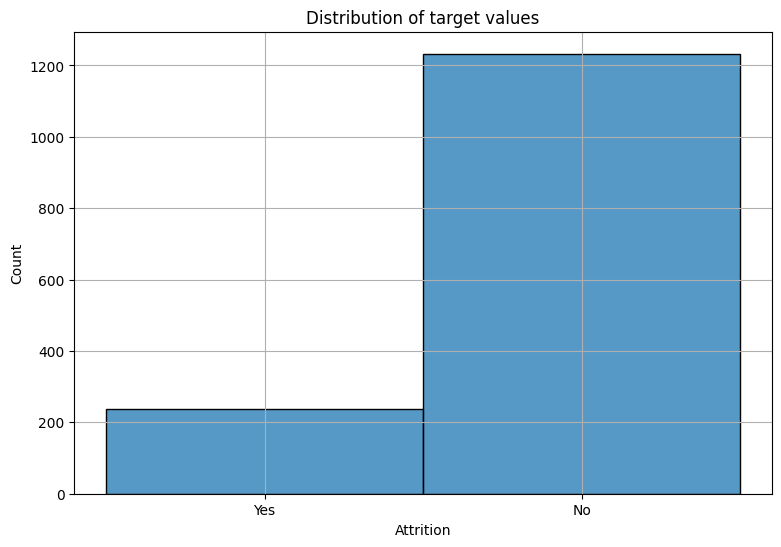

In [6]:
# distribution of target
FIGSIZE = (9, 6)
plt.figure(figsize=FIGSIZE)
plt.title('Distribution of target values')
plt.grid(True)
sns.histplot(data['Attrition'])
plt.show()

#### il dataset è sbilanciato, la classe positiva è minoritaria

In [7]:
# compute the ratio, for class weights
condition = data['Attrition'] == 'Yes'

n_pos = data.loc[condition].shape[0]
n_neg = data.shape[0] - n_pos
ratio = n_neg/n_pos

print('Il rapporto negativi/positivi è:', round(ratio, 2))

Il rapporto negativi/positivi è: 5.2


In [8]:
# contiamo il numero di valori distinti
# per decidere quali trattare come categoriche e quali come numeriche
count_df = compute_distinct(data)

count_df

,col,count
0,Age,43
1,Attrition,2
2,EnvironmentSatisfaction,4
3,MaritalStatus,3
4,TravelForWork,3
5,SalaryLevel,886
6,JobFunction,3
7,CommuteLength,29
8,EducationalLevel,5
9,EducationField,6


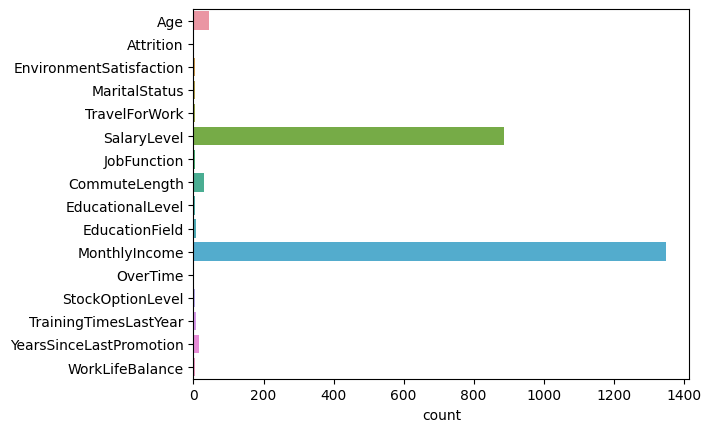

In [9]:
sns.barplot(y=MY_COLUMNS, x=count_df['count'])
plt.show()

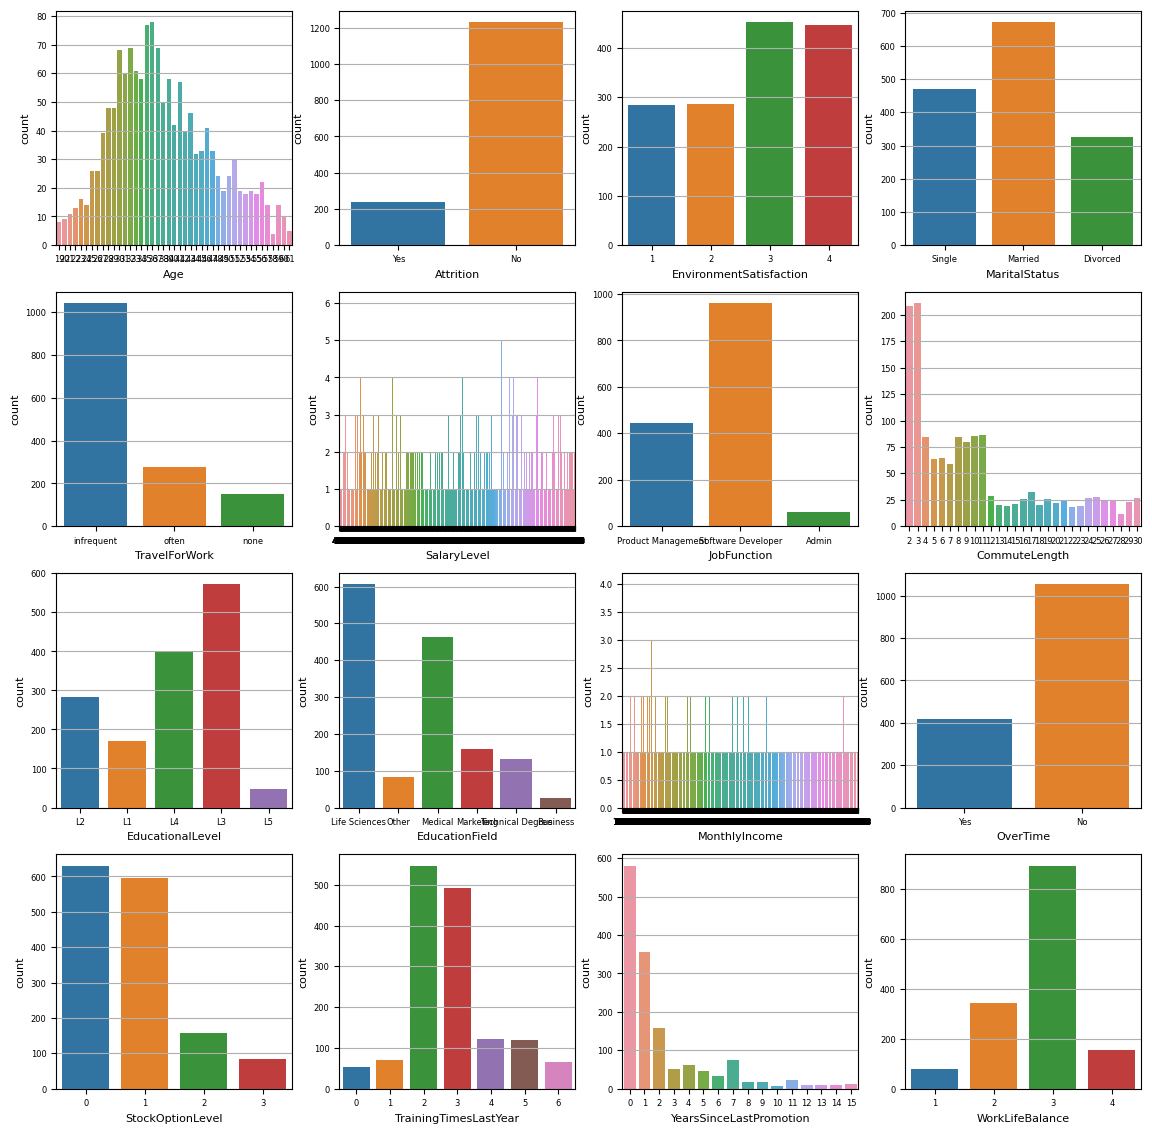

In [10]:
FIGSIZE = (14, 14)
plt.figure(figsize=FIGSIZE)

# iterasu tutte le colonne
for i, col in enumerate(MY_COLUMNS):
    plt.subplot(4, 4, i+1)
    plt.grid(True)
    cp = sns.countplot(x=data[col])
    cp.set_xlabel(col,fontsize=8)
    cp.set_ylabel('count',fontsize=8)
    cp.tick_params(labelsize=6)
plt.show()

#### Dalle analisi sopra si giustifica di considerare **Monthly Income** e **Salary Level** come continue numeriche e tutte le altre come categoriche